# GNR638  - Mini Project II


In [1]:
!pip install numpy==1.24.4 pillow==10.2 scikit-image==0.21 torch-summary

In [70]:
import os
import cv2
import sys
import json
import torch
import random
import subprocess
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset
from torch.optim import lr_scheduler
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from torchsummary import summary
from PIL import Image

## **Part A** - Loading Data and Resizing images

In [3]:
!wget -O train_sharp.zip https://iitbacin-my.sharepoint.com/:u:/g/personal/23d2031_iitb_ac_in/EQBj3agHPEFJiE12ohOMZvIBypuc-vJSpdYqblaFKw92rw?download=1

--2024-04-06 13:42:10--  https://iitbacin-my.sharepoint.com/:u:/g/personal/23d2031_iitb_ac_in/EQBj3agHPEFJiE12ohOMZvIBypuc-vJSpdYqblaFKw92rw?download=1
Resolving iitbacin-my.sharepoint.com (iitbacin-my.sharepoint.com)... 13.107.136.10, 13.107.138.10, 2620:1ec:8f8::10, ...
Connecting to iitbacin-my.sharepoint.com (iitbacin-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/23d2031_iitb_ac_in/Documents/train_sharp.zip?ga=1 [following]
--2024-04-06 13:42:11--  https://iitbacin-my.sharepoint.com/personal/23d2031_iitb_ac_in/Documents/train_sharp.zip?ga=1
Reusing existing connection to iitbacin-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 34261573976 (32G) [application/x-zip-compressed]
Saving to: ‘train_sharp.zip’

train_sharp.zip     100%[===================>]  31.91G  56.3MB/s    in 10m 22s 

2024-04-06 13:52:33 (52.6 MB/s) - ‘train_sharp.zip’ saved [34261573976/34261573976]



In [4]:
!unzip train_sharp.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/train_sharp/160/00000031.png  
  inflating: train/train_sharp/160/00000042.png  
  inflating: train/train_sharp/160/00000059.png  
  inflating: train/train_sharp/160/00000020.png  
  inflating: train/train_sharp/160/00000057.png  
  inflating: train/train_sharp/160/00000009.png  
  inflating: train/train_sharp/160/00000007.png  
  inflating: train/train_sharp/160/00000038.png  
  inflating: train/train_sharp/160/00000069.png  
  inflating: train/train_sharp/160/00000012.png  
  inflating: train/train_sharp/160/00000048.png  
  inflating: train/train_sharp/160/00000052.png  
  inflating: train/train_sharp/160/00000047.png  
  inflating: train/train_sharp/160/00000082.png  
  inflating: train/train_sharp/160/00000001.png  
  inflating: train/train_sharp/160/00000033.png  
  inflating: train/train_sharp/160/00000091.png  
  inflating: train/train_sharp/160/00000046.png  
  inflating: train/train_sharp/160/00000078.png  

In [5]:
DATA_DIR = "/content/train/train_sharp"

In [53]:
IMG_SIZE = (256,448)

transform_train = transforms.Compose([
        transforms.Resize((IMG_SIZE[0], IMG_SIZE[1])),
        transforms.ToTensor(),
        ])

# Load data from folders
train_dataset = datasets.ImageFolder(root=DATA_DIR, transform=transform_train)

In [54]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False)
class_names = train_dataset.classes

In [55]:
inputs, _ = next(iter(train_loader))
print(inputs.shape)

torch.Size([8, 3, 256, 448])


### Some Utilities

In [56]:
def show_images_with_labels(images, class_names):
        num_images = len(images)
        rows = int(np.sqrt(num_images))
        cols = int(np.ceil(num_images / rows))
        fig, axes = plt.subplots(rows, cols)
        for i, ax in enumerate(axes.flatten()):
            if i < num_images:
                img = images[i].permute(1, 2, 0)  # Convert (C, H, W) to (H, W, C)
                ax.imshow(img)
                ax.set_title(f"Class: {class_names[i]}")
                ax.axis('off')
            else:
                ax.axis('off')
        plt.tight_layout()
        plt.show()


def visualize(dataset, class_names, indices = None, num_images = 9,):
    if not indices:
      indices = random.sample(range(len(train_dataset)), num_images)
    images, labels = [], []
    for index in indices:
      image, label = dataset[index]
      images.append(image)
      labels.append(label)
    class_labels = [class_names[label] for label in labels]
    show_images_with_labels(images, class_labels)

In [57]:
def PSNR(input, target, EPS=1e-6):
    return -10*torch.log10(torch.mean((input - target) ** 2, dim=[1, 2, 3])+EPS)

In [58]:
def MSE(input, target):
    return torch.mean((input - target) ** 2, dim=[1, 2, 3])

## **Part B** - Apply gaussain kernels

In [59]:
# Custom transformation to apply Gaussian filter to each image
class ApplyGaussianFilter(object):
    def __init__(self, kernel_size, sigma):
        self.kernel_size = kernel_size
        self.sigma = sigma

    def __call__(self, img):
        img_np = np.array(img)
        img_filtered = cv2.GaussianBlur(img_np, (self.kernel_size, self.kernel_size), self.sigma)
        img_filtered = Image.fromarray(img_filtered)
        return img_filtered

# Define transformations
transform_gaussian_3x3 = transforms.Compose([
    transforms.Resize((IMG_SIZE[0], IMG_SIZE[1])),
    ApplyGaussianFilter(kernel_size=3, sigma=0.3),
    transforms.ToTensor()
])

transform_gaussian_7x7 = transforms.Compose([
    transforms.Resize((IMG_SIZE[0], IMG_SIZE[1])),
    ApplyGaussianFilter(kernel_size=7, sigma=1),
    transforms.ToTensor()
])

transform_gaussian_11x11 = transforms.Compose([
    transforms.Resize((IMG_SIZE[0], IMG_SIZE[1])),
    ApplyGaussianFilter(kernel_size=11, sigma=1.6),
    transforms.ToTensor()
])

# Apply transformations to your dataset
dataset_gaussian_3x3 = datasets.ImageFolder(root=DATA_DIR, transform=transform_gaussian_3x3)
dataset_gaussian_7x7 = datasets.ImageFolder(root=DATA_DIR, transform=transform_gaussian_7x7)
dataset_gaussian_11x11 = datasets.ImageFolder(root=DATA_DIR, transform=transform_gaussian_11x11)

train_loader_3x3 = DataLoader(dataset_gaussian_3x3, batch_size=8, shuffle=False)
train_loader_7x7 = DataLoader(dataset_gaussian_7x7, batch_size=8, shuffle=False)
train_loader_11x11 = DataLoader(dataset_gaussian_11x11, batch_size=8, shuffle=False)

### Visualization

In [60]:
indices = random.sample(range(len(train_dataset)), 9)

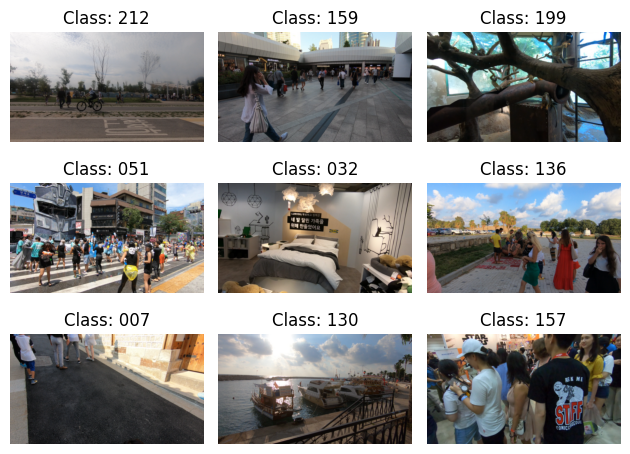

In [61]:
visualize(train_dataset, class_names, indices)

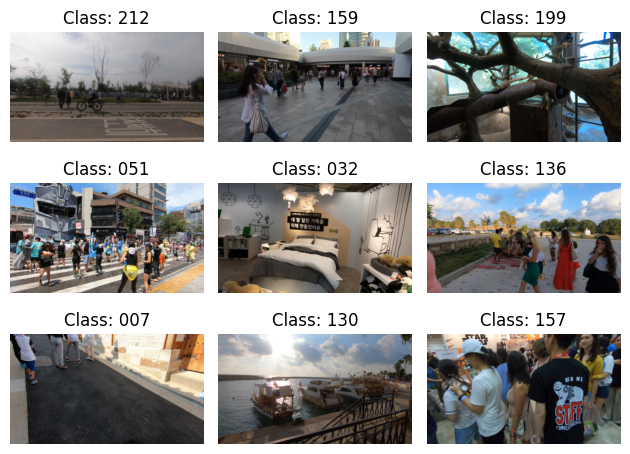

In [62]:
visualize(dataset_gaussian_3x3, class_names, indices)

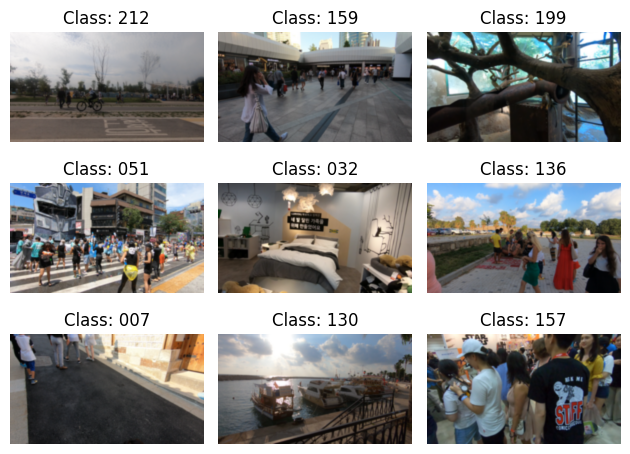

In [63]:
visualize(dataset_gaussian_7x7, class_names, indices)

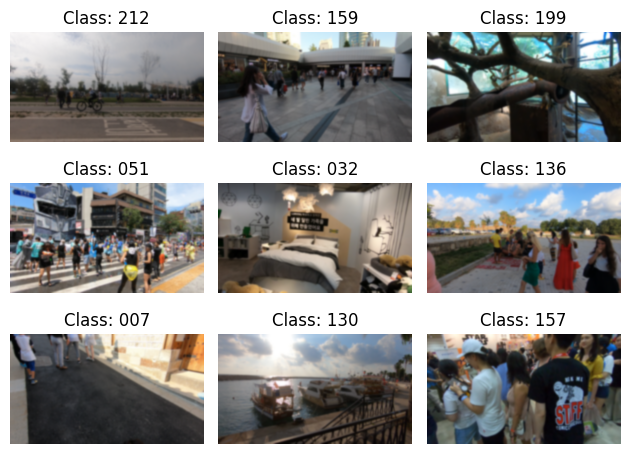

In [64]:
visualize(dataset_gaussian_11x11, class_names,indices)

In [76]:
import torch
from torchvision import datasets, transforms
from PIL import Image
import numpy as np
import cv2
from torch.utils.data import Dataset

class GaussianBlurredDataset(Dataset):
    def __init__(self, root_dir, transform=None, kernel_sizes=[3, 7, 11], sigmas=[0.3, 1, 1.6]):
        self.root_dir = root_dir
        self.transform = transform
        self.kernel_sizes = kernel_sizes
        self.sigmas = sigmas

        # Load original images
        self.original_dataset = datasets.ImageFolder(root=root_dir, transform=transforms.ToTensor())

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        original_image, _ = self.original_dataset[idx]

        blurred_images = []
        for kernel_size, sigma in zip(self.kernel_sizes, self.sigmas):
            # Apply Gaussian filter
            img_np = np.array(original_image)
            filtered_image = cv2.GaussianBlur(img_np, (kernel_size, kernel_size), sigma)
            blurred_image = Image.fromarray(filtered_image)

            # Apply transformations
            if self.transform:
                blurred_image = self.transform(blurred_image)

            blurred_images.append(blurred_image)

        # Return a tuple containing blurred images and original image
        return blurred_images, original_image

# Define transformations
IMG_SIZE = (256, 256)
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor()
])

# Define dataset with all blurred images and original images
dataset = GaussianBlurredDataset(root_dir=DATA_DIR, transform=transform)

# Shuffle the dataset
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [77]:
images,labels = next(iter(dataloader))

error: OpenCV(4.8.0) /io/opencv/modules/core/src/matrix.cpp:1099: error: (-215:Assertion failed) dims <= 2 && step[0] > 0 in function 'locateROI'


## Denoising Auto-Encoder Architecture (U-NET)

In [65]:
import torch.nn as nn
from torch.nn import Linear, ReLU, MSELoss, L1Loss, Sequential, \
 Conv2d, ConvTranspose2d, MaxPool2d, AdaptiveAvgPool2d, Module, \
  BatchNorm2d, Sigmoid, Dropout

In [71]:
class DenoisingAE(nn.Module):
    def __init__(self):
        super(DenoisingAE, self).__init__()
        self.encoder = Sequential(
            Conv2d(3, 32, kernel_size = (3,3), padding = "same"),
            ReLU(),
            MaxPool2d((2,2), padding = 0),
            Conv2d(32, 64, kernel_size = (3,3), padding = "same"),
            ReLU(),
            MaxPool2d((2,2), padding = 0),
            Conv2d(64, 128, kernel_size = (3,3), padding = "same"),
            ReLU(),
            MaxPool2d((2,2), padding = 0)
        )
        self.decoder = Sequential(
            ConvTranspose2d(128, 128, kernel_size = (3,3), stride = 2, padding = 0),
            ReLU(),
            ConvTranspose2d(128, 64, kernel_size = (3,3), stride = 2, padding = 0),
            ReLU(),
            ConvTranspose2d(64, 32, kernel_size = (3,3), stride = 2, padding = 0),
            ReLU(),
            ConvTranspose2d(32, 3, kernel_size = (3,3), stride = 1, padding = 1),
            Sigmoid()
        )

    def forward(self, images):
        x = self.encoder(images)
        x = self.decoder(x)
        return x

In [72]:
print(summary(DenoisingAE(), torch.zeros((1,3,256,448))))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 128, 32, 56]         --
|    └─Conv2d: 2-1                       [-1, 32, 256, 448]        896
|    └─ReLU: 2-2                         [-1, 32, 256, 448]        --
|    └─MaxPool2d: 2-3                    [-1, 32, 128, 224]        --
|    └─Conv2d: 2-4                       [-1, 64, 128, 224]        18,496
|    └─ReLU: 2-5                         [-1, 64, 128, 224]        --
|    └─MaxPool2d: 2-6                    [-1, 64, 64, 112]         --
|    └─Conv2d: 2-7                       [-1, 128, 64, 112]        73,856
|    └─ReLU: 2-8                         [-1, 128, 64, 112]        --
|    └─MaxPool2d: 2-9                    [-1, 128, 32, 56]         --
├─Sequential: 1-2                        [-1, 3, 263, 455]         --
|    └─ConvTranspose2d: 2-10             [-1, 128, 65, 113]        147,584
|    └─ReLU: 2-11                        [-1, 128, 65, 113]        --
|